In [2]:
import numpy as np
import math
import statistics as stat
import random
import pandas as pd

from scipy.optimize import isotonic_regression
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import interp1d

from matchings import cross_bin_matching, same_bin_matching, immediate_neighbor_matching, max_weight_matching
from scipy.stats import norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


lblue = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred = (0.69411765, 0.01568627, 0.05490196)

In [37]:
def SCINT_test(X, Y, M, nperm=500):
    Del_X = np.array([X[i]-X[j] for (i,j) in M])
    Del_Y = np.array([Y[i]-Y[j] for (i,j) in M])
    
    D_S = np.einsum('ij, j, j -> i', 
                    (np.random.rand(nperm, len(M)) < .5), 
                    Del_X, 
                    Del_Y)
    
    return round((1+np.sum(D_S <= 0))/(1+nperm),3)

def marg_indep_test(X, Y, nperm=500):
    T = np.dot(X,Y)
    T_S = []
    for t in range(nperm):
        perm = np.random.permutation(len(X))
        X_S = X[perm]    
        T_S.append(np.dot(X_S,Y))
    return round(np.mean([a>T for a in T_S]),3)
    

## Data setup

In [9]:
data = pd.read_csv('diabetes.csv')
data = data.dropna()
print(data.shape)
print(list(data.columns))
data.head()

(768, 9)
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


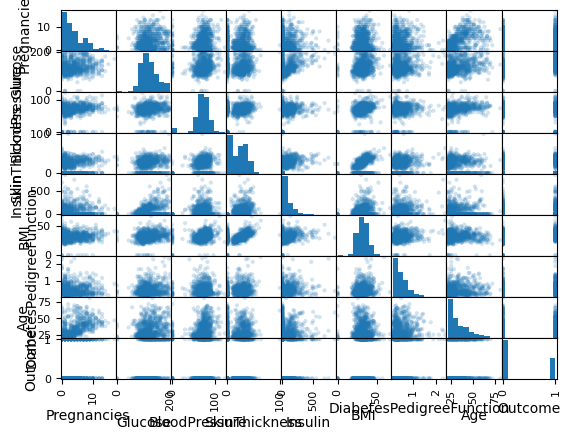

In [10]:
pd.plotting.scatter_matrix(data, alpha=0.2);

## Checking Stoch Monotonicity

<Axes: xlabel='Age', ylabel='Outcome'>

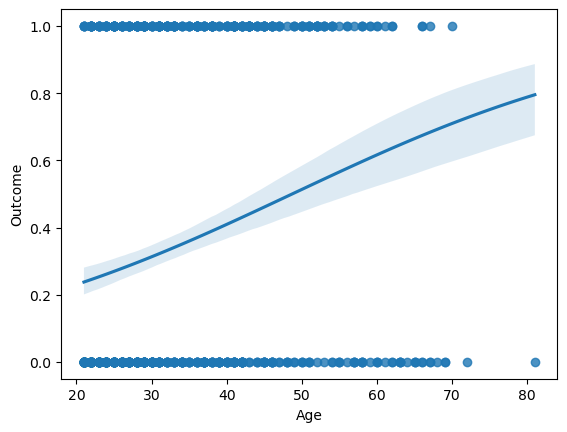

In [11]:
import seaborn as sns
sns.regplot(x=data["Age"],y=data["Outcome"], logistic=True)

## Train-test Split

In [12]:
N = data.shape[0]
Itr, Ite = np.array_split(np.random.permutation(N), 2)
ntr, nte = len(Itr), len(Ite)
train_data = data.iloc[Itr]
test_data = data.iloc[Ite]

## Run Tests

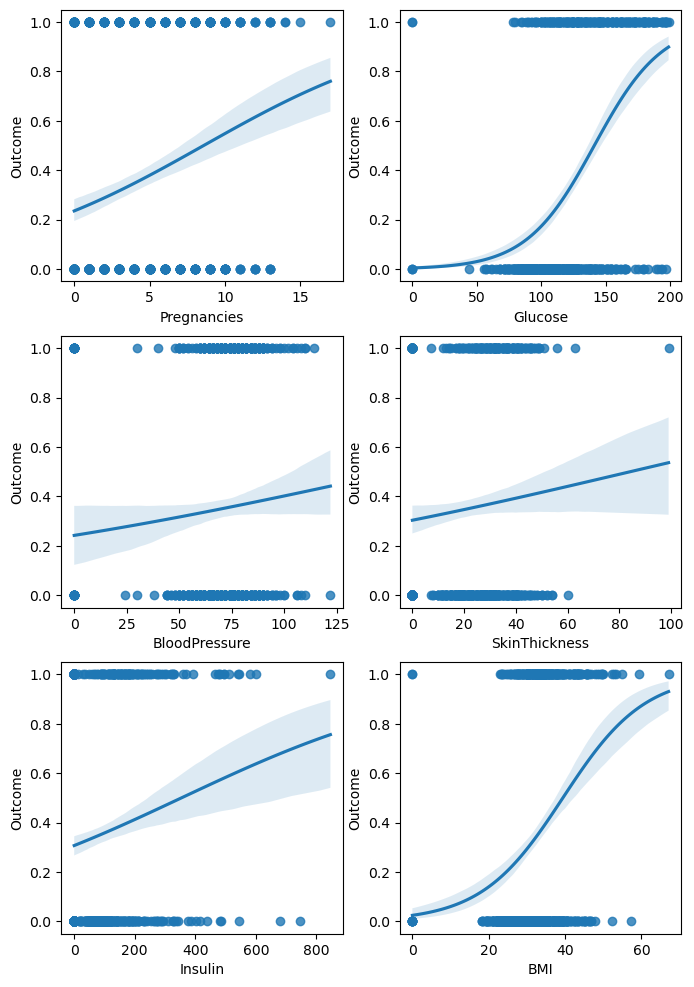

In [63]:
fig, ax = plt.subplots(3,2, figsize =(8,12))
sns.regplot(x=data["Pregnancies"],y=data["Outcome"], logistic=True,ax=ax[0,0]);
sns.regplot(x=data["Glucose"],y=data["Outcome"], logistic=True,ax=ax[0,1]);
sns.regplot(x=data["BloodPressure"],y=data["Outcome"], logistic=True,ax=ax[1,0]);
sns.regplot(x=data["SkinThickness"],y=data["Outcome"], logistic=True,ax=ax[1,1]);
sns.regplot(x=data["Insulin"],y=data["Outcome"], logistic=True,ax=ax[2,0]);
sns.regplot(x=data["BMI"],y=data["Outcome"], logistic=True,ax=ax[2,1]);

In [54]:
## neighbor matching
Z = np.array(test_data["Age"])
X = np.array(test_data["Outcome"])
result = pd.DataFrame(columns = ['Y', 'Marginal pvalue', 'Conditional pvalue', 'Control pvalue', 'length'])

for i in range(6):
    Y = np.array(test_data.iloc[:,i])
    M_nbhd = immediate_neighbor_matching(Y, Z)

    # fake data generation
    o = np.argsort(train_data["Age"])
    prob = isotonic_regression(train_data.Outcome[Itr[o]]).x
    f = interp1d(train_data.Age[Itr[o]], prob, kind='next', assume_sorted=True, fill_value='extrapolate')
    mu_hat = f(Z)
    X_fake = (np.random.rand(nte) <= mu_hat)*1
    
    result = result._append({'Y' : list(data.columns)[i], 
                    'Marginal pvalue' : marg_indep_test(np.array(X),np.array(Y)), 
                    'Conditional pvalue' : SCINT_test(X ,Y, M_nbhd), 
                    'Control pvalue' : SCINT_test(X_fake ,Y, M_nbhd), 
                    'length' : len(M_nbhd)}, ignore_index = True)
result = pd.DataFrame(result)
print(result)

               Y  Marginal pvalue  Conditional pvalue  Control pvalue length
0    Pregnancies            0.000               0.429           0.126     80
1        Glucose            0.000               0.002           0.112     97
2  BloodPressure            0.056               0.094           0.884     94
3  SkinThickness            0.178               0.006           0.333     71
4        Insulin            0.000               0.080           0.265     58
5            BMI            0.000               0.002           0.094     92


/var/folders/0q/1br6tq4j3td60p7x3c_np0xh0000gn/T/ipykernel_25629/2410195571.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = result._append({'Y' : list(data.columns)[i],


In [56]:
## cross-bin matching
K = 150
Z = np.array(test_data["Age"])
X = np.array(test_data["Outcome"])
result = pd.DataFrame(columns = ['Y', 'Marginal pvalue', 'Conditional pvalue', 'Control pvalue', 'length'])

for i in range(6):
    Y = np.array(test_data.iloc[:,i])
    M_cb = cross_bin_matching(Y,Z,K)

    # fake data generation
    o = np.argsort(train_data["Age"])
    prob = isotonic_regression(train_data.Outcome[Itr[o]]).x
    f = interp1d(train_data.Age[Itr[o]], prob, kind='next', assume_sorted=True, fill_value='extrapolate')
    mu_hat = f(Z)
    X_fake = (np.random.rand(nte) <= mu_hat)*1
    
    result = result._append({'Y' : list(data.columns)[i], 
                    'Marginal pvalue' : marg_indep_test(np.array(X),np.array(Y)), 
                    'Conditional pvalue' : SCINT_test(X ,Y, M_cb), 
                    'Control pvalue' : SCINT_test(X_fake ,Y, M_cb), 
                    'length' : len(M_cb)}, ignore_index = True)
result = pd.DataFrame(result)
print(result)

               Y  Marginal pvalue  Conditional pvalue  Control pvalue length
0    Pregnancies            0.000               0.409           0.832    106
1        Glucose            0.000               0.002           0.697    124
2  BloodPressure            0.068               0.455           0.551    123
3  SkinThickness            0.184               0.064           0.936    113
4        Insulin            0.002               0.004           0.878     84
5            BMI            0.000               0.002           0.307    130


/var/folders/0q/1br6tq4j3td60p7x3c_np0xh0000gn/T/ipykernel_25629/120684586.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = result._append({'Y' : list(data.columns)[i],
